In [104]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import pickle
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import shap
import time
from numpy import concatenate
Scaler = MinMaxScaler()

In [105]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short: ')
all_df=pd.read_csv(lakename+'_Observation_df.csv')

SyntaxError: EOL while scanning string literal (<ipython-input-105-eade292967cb>, line 5)

In [71]:
# Specify the training year
year = all_df['Date'].apply(lambda d:d.year).unique()
print('Dataset contains years:{}'.format(year))#[2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016] 
num_trainingyr = int(input('Number of years for training:'))
training_yr = []
for i in range(num_trainingyr):
    yr = int(input('Training year:'))
    training_yr.append(yr)

Dataset contains years:[2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]
Number of years for training:8
Training year:2005
Training year:2006
Training year:2007
Training year:2008
Training year:2009
Training year:2010
Training year:2011
Training year:2012


# GBR model

In [72]:
# Load testing dataset(Daily data)
def read_daily_test_df(test_time,features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    Lake_HydMet = Lake_HydMet[(Lake_HydMet['Date']>=test_time[0])&(Lake_HydMet['Date']<=test_time[1])].dropna()
    return Lake_HydMet

In [73]:
def training_cv(df,features,nutrient,year):
    df['YY'] = df['Date'].apply(lambda d:d.year)
    df = df[df['YY'].isin(year)].dropna()
    X_train = df[features]
    y_train = df[nutrient].values

    GBR = GradientBoostingRegressor(random_state=101)
    n_estimators = [int(x) for x in np.arange(40,140,20)]
    max_depth=[int(x) for x in np.arange(5,10,1)]
    learning_rate = [x for x in [0.01,0.1,1]]
    subsample = [x for x in [0.7,0.8,0.9,1]]
    param_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'subsample':subsample}
    GBR_rs = RandomizedSearchCV(estimator = GBR,param_distributions = param_grid,n_iter = 30,cv = 5,verbose = 0)
    GBR_rs.fit(X_train,y_train)
    #print(GBR_rs.best_params_)
    GBR.set_params(**GBR_rs.best_params_,random_state=101).fit(X_train,y_train)
    rmse = np.sqrt(-cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'r2')
    print('Training dataset evaluation:')
    print("RMSE %.2f (+/- %.2f)" % (rmse.mean(), rmse.std()))
    print("R2 %.2f (+/- %0.2f)" % (r2.mean(), r2.std()))
    pickle.dump(GBR, open("GBR."+nutrient.split('(')[0]+".dat", "wb"))

In [74]:
def predict(Lake_Nut,df,features,nutrient,test_time,ylim):
    #load the target GBR model
    GBR = pickle.load(open("GBR."+nutrient.split('(')[0]+".dat", "rb"))
    #predict yhat using test_X
    Lake_Nut[nutrient] =GBR.predict(Lake_Nut[features])
    nutrient_compare = Lake_Nut[['Date',nutrient]].merge(df[['Date',nutrient]],
                                                          how = 'inner',on = 'Date').dropna()
    nutrient_compare.columns = ['Date','Prediction','True']
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                  end = test_time[1]),
                    columns = ['Date'])
    Lake_Nut_gap = Date.merge(Lake_Nut,how = 'left',on = 'Date')
    #nutrient_compare['Prediction_7d'] = Erken_Nut[nutrient]

    RMSE = np.sqrt(mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction']))
    #plot time-series comparison
    f2,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Lake_Nut_gap.plot(x = 'Date',y =nutrient,c = 'b',ax = ax2[0],label = 'Predicted '+nutrient)
    Lake_Nut[nutrient] = Lake_Nut[nutrient].rolling(7,min_periods = 1).mean() # take the 7-day moving mean
    Lake_Nut_gap[nutrient] = Lake_Nut_gap[nutrient].rolling(7,min_periods = 1).mean()
    Lake_Nut_gap.plot(x = 'Date',y =nutrient,c = 'k',ax = ax2[0],label = 'Predicted 7d-averaged '+nutrient)
    df[['Date',nutrient]].plot(x = 'Date',y =nutrient,style = 'ro',ms = 7,alpha = 0.7,ax = ax2[0],label = 'Observation')
    ax2[0].text(0.2, 0.8, 'RMSE:{}'.format(round(RMSE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')
    ax2[0].set_xlim((test_time[0],test_time[1]))
    ax2[0].set_ylim(ylim)
    
    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    
    return Lake_Nut,f2

In [ ]:
print(all_df.info())
n_feature = int(input('Number of features used for training'))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),pd.Timestamp(int(input('test ends in year:')),1,1)]

In [83]:
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'
testing_daily_df = read_daily_test_df(test_time,features,file) 

Nutrient: NO3N


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Training dataset evaluation:
RMSE 194.15 (+/- 68.75)
R2 -0.20 (+/- 0.60)
Figure name:LV_GBR_NO3N


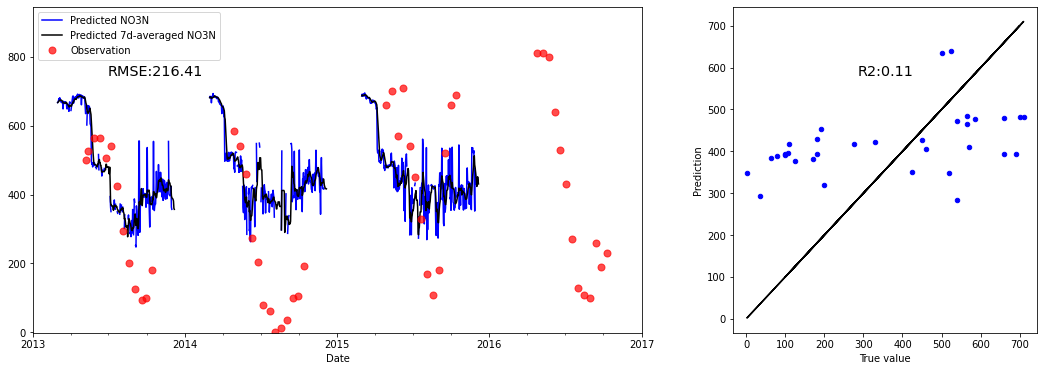

In [84]:
## Predict nutrient 1
nutrient = input('Nutrient: ')
features.pop(0) # remove 'Date' from features
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (-1,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
os.chdir('..\\Scenario2\\GBR')
fig_name = input('Figure name:')
f2.savefig(fig_name+'.png',dpi = 500)

Nutrient: O2
Add features? (Y/N)Y
New feature:NO3N
['AirP', 'AirT', 'RelHum', 'SWR', 'Prec', 'CC', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'NO3N']
Add features? (Y/N)N


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Training dataset evaluation:
RMSE 1.76 (+/- 0.27)
R2 -0.55 (+/- 0.25)
Figure name:LV_GBR_O2


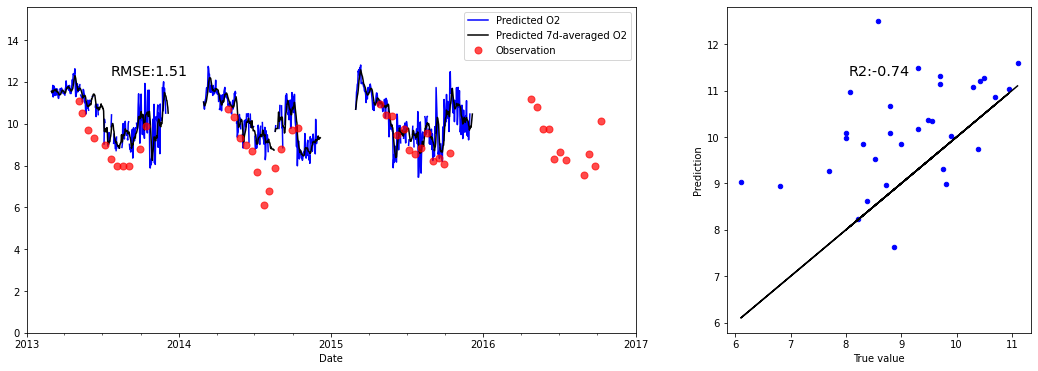

In [85]:
## Predict nutrient 2
nutrient = input('Nutrient: ')

delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
fig_name = input('Figure name:')
f2.savefig(fig_name+'.png',dpi = 500)

Nutrient: NH4N
Add features? (Y/N)Y
New feature:O2
['AirP', 'AirT', 'RelHum', 'SWR', 'Prec', 'CC', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'NO3N', 'O2']
Add features? (Y/N)N


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Training dataset evaluation:
RMSE 11.91 (+/- 3.67)
R2 -0.25 (+/- 0.76)
Figure name:LV_GBR_NH4N


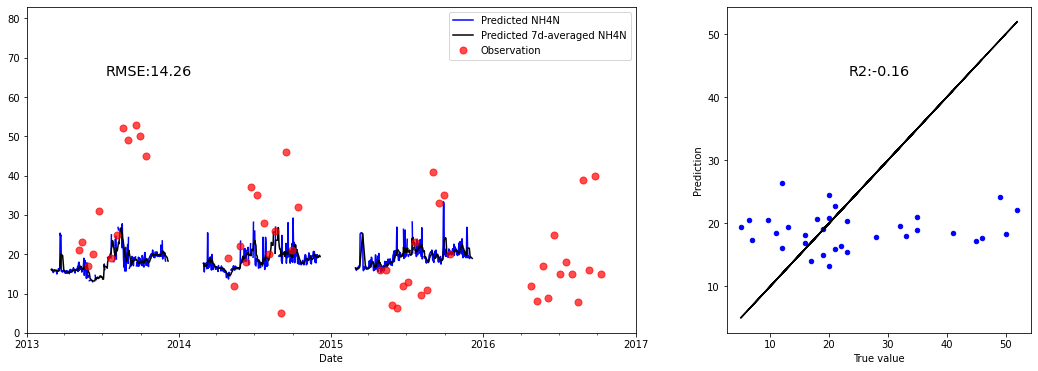

In [86]:
## Predict nutrient 3
nutrient = input('Nutrient: ')

delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
fig_name = input('Figure name:')
f2.savefig(fig_name+'.png',dpi = 500)

Nutrient: PO4P
Add features? (Y/N)N


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Training dataset evaluation:
RMSE 2.28 (+/- 0.58)
R2 -0.29 (+/- 0.33)
Figure name:LV_GBR_PO4P


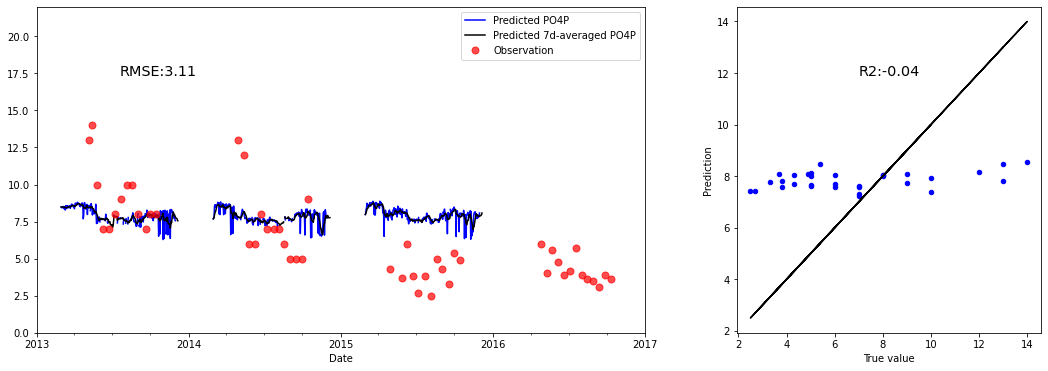

In [87]:
## Predict nutrient 4
nutrient = input('Nutrient: ')

delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
fig_name = input('Figure name:')
f2.savefig(fig_name+'.png',dpi = 500)

Nutrient: TOTP
Add features? (Y/N)N


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Training dataset evaluation:
RMSE 4.46 (+/- 0.97)
R2 -0.40 (+/- 0.34)
Figure name:LV_GBR_TOTP


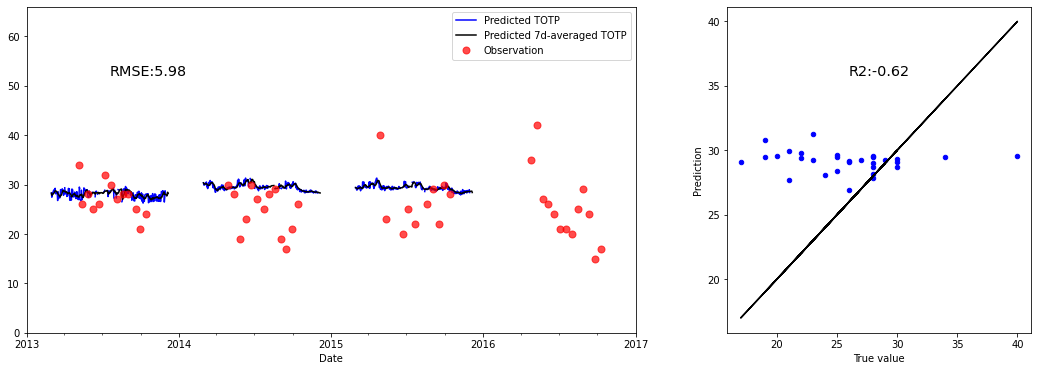

In [88]:
## Predict nutrient 5
nutrient = input('Nutrient: ')

delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
fig_name = input('Figure name:')
f2.savefig(fig_name+'.png',dpi = 500)

Nutrient: TOTN
Add features? (Y/N)N


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Training dataset evaluation:
RMSE 143.14 (+/- 58.91)
R2 0.27 (+/- 0.31)
Figure name:LV_GBR_TOTN


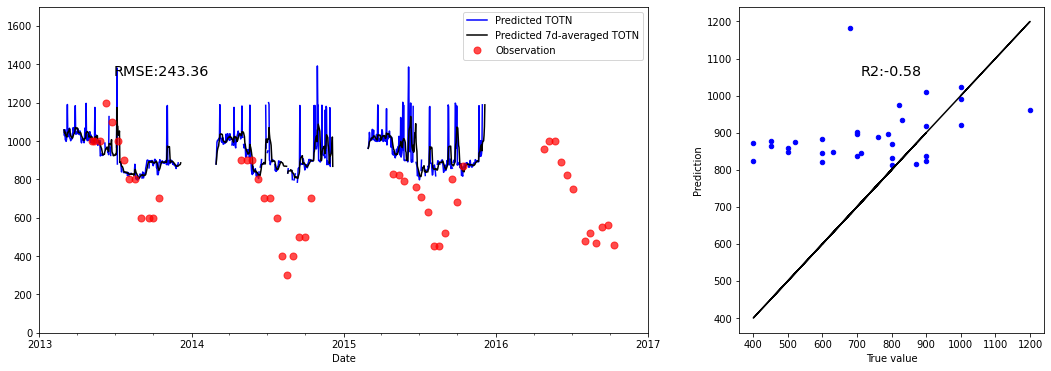

In [89]:
## Predict nutrient 6
nutrient = input('Nutrient: ')

delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
fig_name = input('Figure name:')
f2.savefig(fig_name+'.png',dpi = 500)

Nutrient: SiO2
Delete features? (Y/N)N
Add features? (Y/N)N


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Training dataset evaluation:
RMSE 1.05 (+/- 0.30)
R2 0.26 (+/- 0.32)
Figure name:LV_GBR_SiO2


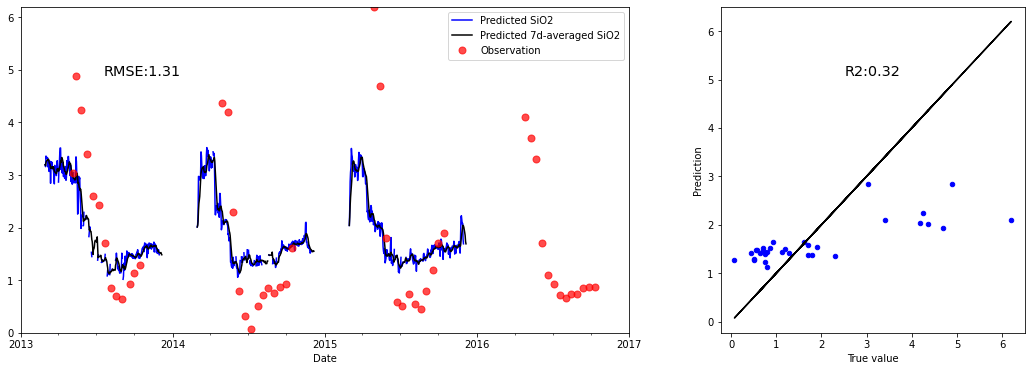

In [95]:
## Predict nutrient 7
nutrient = input('Nutrient: ')
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
    
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')  
    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
fig_name = input('Figure name:')
f2.savefig(fig_name+'.png',dpi = 500)

Nutrient: TOC
Add features? (Y/N)Y
New feature:SiO2
['AirP', 'AirT', 'RelHum', 'SWR', 'Prec', 'CC', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'NO3N', 'O2', 'SiO2']
Add features? (Y/N)N


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Training dataset evaluation:
RMSE 0.78 (+/- 0.32)
R2 -1.48 (+/- 0.86)
Figure name:LV_GBR_TOC


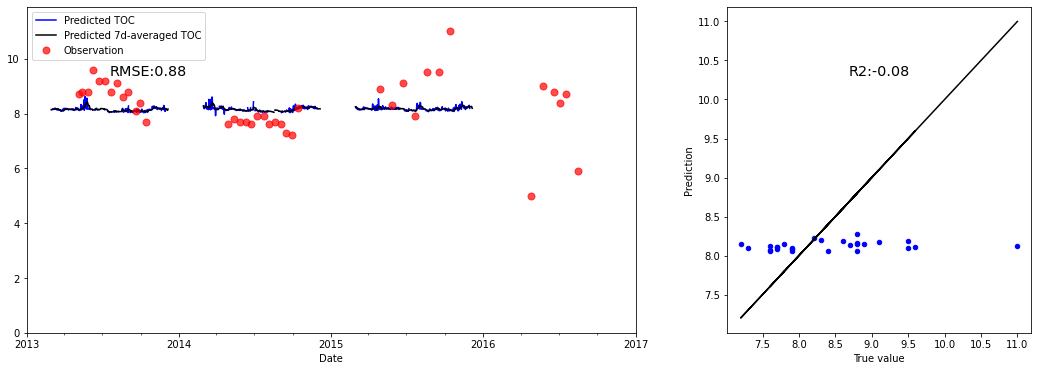

In [96]:
## Predict nutrient 8
nutrient = input('Nutrient: ')
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
    
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
fig_name = input('Figure name:')
f2.savefig(fig_name+'.png',dpi = 500)

Nutrient: chl-a
Delete features? (Y/N)y
Add features? (Y/N)n


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Training dataset evaluation:
RMSE 4.45 (+/- 1.00)
R2 0.12 (+/- 0.28)
Figure name:LV_GBR_Chl


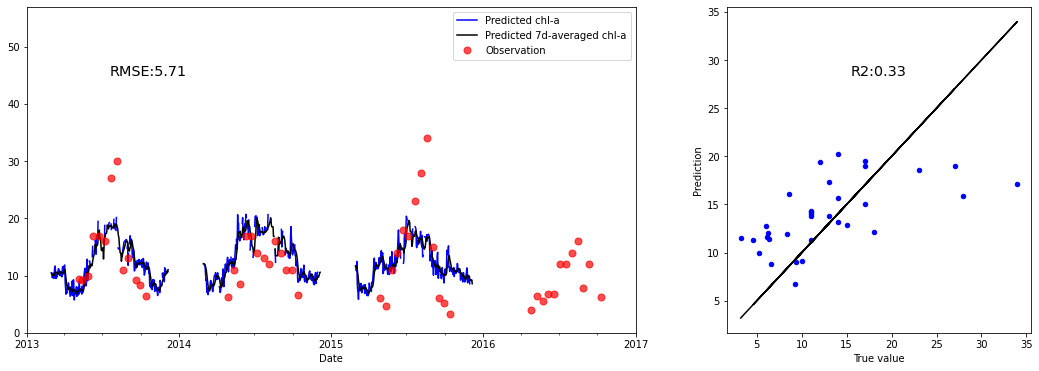

In [98]:
## Predict Chl
nutrient = input('Nutrient: ')

delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
    
model = training_cv(all_df,features,nutrient,training_yr)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
fig_name = input('Figure name:')
f2.savefig(fig_name+'.png',dpi = 500)

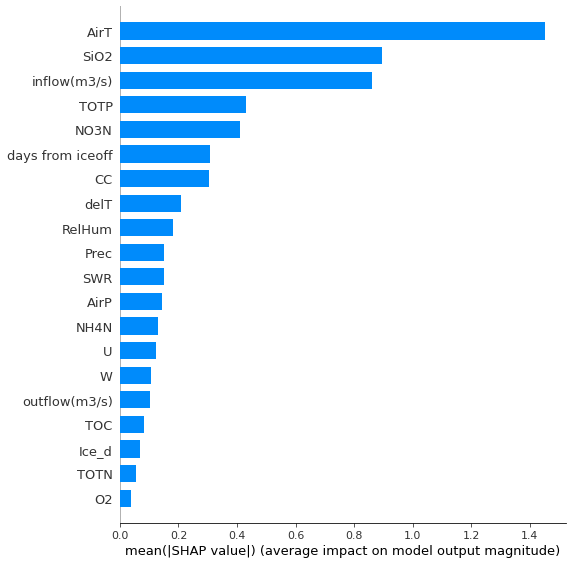

In [103]:
GBR = pickle.load(open('GBR.'+nutrient+'.dat','rb'))
shap_values = shap.TreeExplainer(GBR).shap_values(Lake_Nut[features])
shap.summary_plot(shap_values,Lake_Nut[features],plot_type = 'bar',show=False)
plt.savefig(lakename+'_Feature ranking.png')

In [102]:
Lake_Nut.to_csv(lakename+'_GBR predicted nutrient and Chl.csv',index = False)